<a href="https://colab.research.google.com/github/capajaro/AnalisisResults/blob/main/Spatial_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install PyKrige

In [33]:
import pykrige #biblioteca de geoestadística
import pykrige.kriging_tools as kt #herramientas para exportar e importar archivos .asc con biblioteca PyKrige
from pykrige.ok import OrdinaryKriging #Kriging Ordinario con PyKrige
import pandas as pd #biblioteca de manipulación y análisis de datos
import numpy as np #biblioteca de funciones matemáticas
import matplotlib.pyplot as plt #biblioteca de generación de gráficos
import math 
plt.style.use('ggplot') #estilo para gráficos en matplotlib
% matplotlib inline

In [63]:
def Distance_bt_Stations(lat1, lat2, lon1, lon2):
  R = 6373.0 
  lat1 = math.radians(lat1)
  lat2 = math.radians(lat2)
  lon1 = math.radians(lon1)
  lon2 = math.radians(lon2)

  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

  distance = R * c

  return distance

In [114]:
DataBase = pd.read_excel('/content/Residuals_Before yes FBA yes Zhypo.xlsx')
DataBase.EQID.value_counts()
DataBase_EQ146 = DataBase[DataBase.EQID == 146]
imt = 1
DataBase_EQ146_imt = DataBase_EQ146[DataBase_EQ146.Period == imt]

In [115]:
df = DataBase_EQ146_imt
Stations = df.SSN.values
Lats = df['Station Latitude (deg positive N)'].values
Lons = df['Station Longitude (deg positive E)'].values
dwes = df['dWe Tau Fixed'].values
sigma_GMPE = np.sqrt(np.array([df['Total']]).var())
dBase_Semivar = pd.DataFrame(data = np.zeros([len(Stations)**2,2]), columns = ['Distancia', 'Dif_Epsilons_cuad'])
k = 0
for i_station in range(len(Stations)):
  for j_station in range(len(Stations)):
    lat1 = Lats[i_station]
    lat2 = Lats[j_station]
    lon1 = Lons[i_station]
    lon2 = Lons[j_station]
    eps1 = dwes[i_station]/sigma_GMPE
    eps2 = dwes[j_station]/sigma_GMPE
    distancia = Distance_bt_Stations(lat1, lat2, lon1, lon2)

    dBase_Semivar['Distancia'].iloc[k] = distancia
    dBase_Semivar['Dif_Epsilons_cuad'].iloc[k] = (eps1 - eps2)**2
    k += 1


In [116]:
Rmax = 700
binsize_R = 10
bins_R = list(range(0, Rmax, binsize_R))
bin_R_Mean = [0.5*(bins_R[i]+ bins_R[i+1])
            for i in range(len(bins_R)-1)]
bin_label_R = ['%0.0f<= R < %0.0f' % (bins_R[i], bins_R[i+1])
            for i in range(len(bins_R)-1)]

dBase_Semivar['R_Bin'] = pd.cut(dBase_Semivar['Distancia'], bins=bins_R, labels=bin_label_R)


In [117]:
Dbase_Semivar_Plot = dBase_Semivar.groupby('R_Bin').sum()
Dbase_Semivar_Plot['R_Bin'] = Dbase_Semivar_Plot.index.values
Dbase_Semivar_Plot['Distancia_media']= bin_R_Mean
df_aux = dBase_Semivar.R_Bin.value_counts().sort_index()
Dbase_Semivar_Plot["N_recs"] = dBase_Semivar.R_Bin.value_counts().sort_index().values
Dbase_Semivar_Plot['Semivariograma']= 0.5*Dbase_Semivar_Plot['Dif_Epsilons_cuad']/Dbase_Semivar_Plot["N_recs"]
Dbase_Semivar_Plot = Dbase_Semivar_Plot.dropna()

(0.0, 1.2)

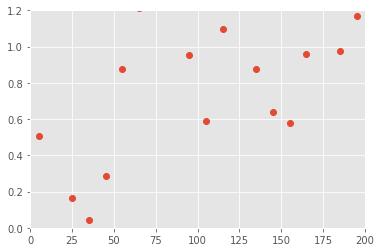

In [118]:
plt.plot(Dbase_Semivar_Plot.Distancia_media, Dbase_Semivar_Plot.Semivariograma, 'o')
plt.xlim([0,200])
plt.ylim([0,1.2])